In [1]:
import torch
import torch.nn as nn
import utility_functions as uf
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = None
importlib.reload(uf)

<module 'utility_functions' from 'c:\\Users\\emilw\\Assignment3\\sepsis-ts\\SepsisTS\\utility_functions.py'>

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data Loading

In [4]:
# Loading the data from helper function
timeseries = uf.TimeseriesTorch('raw_data/', 43)

In [5]:
print(timeseries.train[0][0])
print(timeseries.train[0][1])
print(timeseries.train[1])

tensor([-0.5305, -0.6444, -0.7069, -0.1681, -0.2753, -1.3732, -0.0414, -0.2701,
        -0.4715, -0.1961, -0.2391, -0.3323, -0.3006, -0.0052, -0.3205, -0.3258,
         0.0641, -0.5208, -1.2396, -0.2687, -0.6543, -1.0946,  1.8565, -0.8675,
        -0.8116, -0.2486, -0.3816, -0.3783, -1.9098,  0.8032, -0.9145, -1.1529,
        -0.5172,  1.0191, -0.3347,  0.0107, -0.5110, -0.3339, -0.2847, -0.3229,
         0.3171,  0.0617, -0.2662])
tensor([-0.5305, -0.6444, -0.7069, -0.1681, -0.2753, -1.3732, -0.0414, -0.2701,
        -0.4715, -0.1961, -0.2391, -0.3323, -0.3006, -0.0052, -0.3205, -0.3258,
         0.0641, -0.5208, -1.2396, -0.2687, -0.6543, -1.0946,  1.8565, -0.8675,
        -0.8116, -0.2486, -0.3816, -0.3783, -1.9098,  0.8032, -0.9145, -1.1529,
        -0.5172,  1.0191, -0.3347,  0.0107, -0.5110, -0.3339, -0.2847, -0.3229,
         0.3171,  0.0617, -0.2662])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [6]:
# Loading the data manually
data1 = pd.read_table("raw_data/sepsisexp_timeseries_partition-A.tsv")
data2 = pd.read_table("raw_data/sepsisexp_timeseries_partition-B.tsv")
data3 = pd.read_table("raw_data/sepsisexp_timeseries_partition-C.tsv")
data4 = pd.read_table("raw_data/sepsisexp_timeseries_partition-D.tsv")

In [7]:
# Setting partitions, original authors used these for cross validation. 
# The dataset is split into four partitions (A–D) that are used in the 4-fold cross validation experiments in (Schamoni et al., 2022). 
data1["partition"] = 1
data2["partition"] = 2
data3["partition"] = 3
data4["partition"] = 4

In [8]:
data_orig = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [9]:
df = data_orig.copy()

In [10]:
df.isna().sum()

id                                0
sepsis                            0
severity                          0
timestep                          0
respiratory_minute_volume         0
heart_rate                        0
leukocytes                        0
temperature                       0
partial_co2                       0
respiratory_rate                  0
arterial_ph                       0
bilirubin                         0
blood_urea_nitrogen               0
creatinine                        0
diastolic_bp                      0
fraction_of_inspired_o2           0
mean_bp                           0
partial_pressure_art._o2          0
systolic_bp                       0
thrombocytes                      0
horowitz_index                    0
bun/creatinine_ratio              0
delta-temperature                 0
lactate                           0
bicarbonate                       0
c-reactive_protein                0
hemoglobin                        0
heart_time_volume           

In [11]:
df.shape

(602568, 48)

In [12]:
df["timestep"]


0           0.0
1           0.5
2           1.0
3           1.5
4           2.0
          ...  
602563    190.5
602564    191.0
602565    191.5
602566    192.0
602567    192.5
Name: timestep, Length: 602568, dtype: float64

In [13]:

for partition, group_data in df.groupby('partition'):
    print(f"Partition: {partition}")
    print(group_data.head(), "\n")



Partition: 1
      id  sepsis  severity  timestep  respiratory_minute_volume  heart_rate  \
0  12292       0       0.0       0.0                   0.190898    0.424464   
1  12292       0       0.0       0.5                   0.157654    0.667394   
2  12292       0       0.0       1.0                   0.024678    0.618808   
3  12292       0       0.0       1.5                  -0.208030    0.278706   
4  12292       0       0.0       2.0                  -0.108298   -0.352912   

   leukocytes  temperature  partial_co2  respiratory_rate  arterial_ph  \
0    0.301015    -0.168117    -0.275272          1.879692    -0.041447   
1    0.301015    -0.168117    -0.275272          1.708485    -0.041447   
2    0.301015    -0.732387     1.003408          2.050899     1.804109   
3    0.301015    -0.732387     1.003408          1.366071     1.804109   
4    0.301015    -0.732387     1.094023          1.537278     1.677315   

   bilirubin  blood_urea_nitrogen  creatinine  diastolic_bp  \
0   

In [14]:
#Removes rows for each patient after severity>=2 as we want to predict before the patient get sepsis. 
#Also marks the last (input hour) rows as targets.

def setSepsisColumn(df_input, colName, hours):
    hours = hours * 2
    df_input[colName] = 0
    df_result = df_input[df_input["severity"] < 2]

    for pid in df_result["id"].unique():
        last_n_per_id = df_result[df_result["id"]==pid].tail(hours).index
        #print(last_n_per_id)
        df_result.loc[last_n_per_id, colName] = 1

    return df_result



df_test = df.copy()
df_test = setSepsisColumn(df_test, "2hourSepsis", 2)
df_test = setSepsisColumn(df_test, "4hourSepsis", 4)
df_test = setSepsisColumn(df_test, "6hourSepsis", 6)

In [15]:

unique_ids_count_one_2h = df_test[df_test["sepsis"] == 1]['id'].nunique()
unique_ids_count_zero_2h = df_test[df_test["sepsis"] == 0]['id'].nunique()

print("2h 1:", unique_ids_count_one_2h)
print("2h 0:", unique_ids_count_zero_2h)

print(df_test["2hourSepsis"].value_counts())
print(df_test["2hourSepsis"].value_counts())
print(df_test["4hourSepsis"].value_counts())
print(df_test["6hourSepsis"].value_counts())
print(df_test["sepsis"].value_counts())
print(df["sepsis"].value_counts())


2h 1: 296
2h 0: 979
2hourSepsis
0    421742
1      5100
Name: count, dtype: int64
2hourSepsis
0    421742
1      5100
Name: count, dtype: int64
4hourSepsis
0    416642
1     10200
Name: count, dtype: int64
6hourSepsis
0    411542
1     15300
Name: count, dtype: int64
sepsis
0    237823
1    189019
Name: count, dtype: int64
sepsis
1    364745
0    237823
Name: count, dtype: int64


In [16]:
""" df_sort = df.sort_values(by=['id','timestep'])
df_sort_sepsis = df_sort[df_sort["sepsis"] == 1]

for pid in df_sort_sepsis['id'].unique():
    id_index = df_sort_sepsis[df_sort_sepsis["id"] == pid].index
    for i in range(len(id_index)):
        if i + 8 < len(id_index):
            if 1 in df.loc[id_index[i:i+8], 'severity'].values and 2 in df.loc[id_index[i+1:i+9], 'severity'].values:
                df_sort_sepsis.at[id_index[i], '4hourSepsis'] = 1
                # Drop rows where id_index > i for the same pid
                #df_sort_sepsis.drop(id_index[i+10:], inplace=True) """



' df_sort = df.sort_values(by=[\'id\',\'timestep\'])\ndf_sort_sepsis = df_sort[df_sort["sepsis"] == 1]\n\nfor pid in df_sort_sepsis[\'id\'].unique():\n    id_index = df_sort_sepsis[df_sort_sepsis["id"] == pid].index\n    for i in range(len(id_index)):\n        if i + 8 < len(id_index):\n            if 1 in df.loc[id_index[i:i+8], \'severity\'].values and 2 in df.loc[id_index[i+1:i+9], \'severity\'].values:\n                df_sort_sepsis.at[id_index[i], \'4hourSepsis\'] = 1\n                # Drop rows where id_index > i for the same pid\n                #df_sort_sepsis.drop(id_index[i+10:], inplace=True) '

In [17]:
""" df_sort=df.copy()

df_sort['FirstOccurrenceFlag'] = 0

for pid in df_sort['id'].unique():
    # Extract indices for this patient where sepsis == 1
    patient_indices = df_sort[(df_sort['id'] == pid) & (df_sort['sepsis'] == 1)].index
    
    # Check the condition and flag the first occurrence
    for i in range(len(patient_indices)):
        if i + 8 < len(patient_indices):
            current_indices = patient_indices[i:i+8]
            next_indices = patient_indices[i+1:i+9]
            if 1 in df_sort.loc[current_indices, 'severity'].values and 2 in df_sort.loc[next_indices, 'severity'].values:
                df_sort.at[current_indices[0], 'FirstOccurrenceFlag'] = 1
                break  # Stop after flagging the first occurrence """

" df_sort=df.copy()\n\ndf_sort['FirstOccurrenceFlag'] = 0\n\nfor pid in df_sort['id'].unique():\n    # Extract indices for this patient where sepsis == 1\n    patient_indices = df_sort[(df_sort['id'] == pid) & (df_sort['sepsis'] == 1)].index\n    \n    # Check the condition and flag the first occurrence\n    for i in range(len(patient_indices)):\n        if i + 8 < len(patient_indices):\n            current_indices = patient_indices[i:i+8]\n            next_indices = patient_indices[i+1:i+9]\n            if 1 in df_sort.loc[current_indices, 'severity'].values and 2 in df_sort.loc[next_indices, 'severity'].values:\n                df_sort.at[current_indices[0], 'FirstOccurrenceFlag'] = 1\n                break  # Stop after flagging the first occurrence "

## Preprocess

In [18]:
df_prep = df_test.copy()

In [19]:
cols_to_drop = ["severity",'timestep','partition']
df_prep.drop(columns=cols_to_drop, inplace=True)

In [20]:
df_2hr = df_prep.drop(["4hourSepsis", "6hourSepsis", ], axis=1)
df_4hr = df_prep.drop(["2hourSepsis", "6hourSepsis", ], axis=1)
df_6hr = df_prep.drop(["2hourSepsis", "4hourSepsis", ], axis=1)
df_6hr

,id,sepsis,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,arterial_ph,bilirubin,blood_urea_nitrogen,creatinine,diastolic_bp,fraction_of_inspired_o2,mean_bp,partial_pressure_art._o2,systolic_bp,thrombocytes,horowitz_index,bun/creatinine_ratio,delta-temperature,lactate,bicarbonate,c-reactive_protein,hemoglobin,heart_time_volume,lymphocytes,sodium,pancreatic_lipase,procalcitonin,quick_score,oxygen_saturation,blood_glucose,base_excess,chloride,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,6hourSepsis
0,12292,0,0.190898,0.424464,0.301015,-0.168117,-0.275272,1.879692,-0.041447,0.179544,1.445381,2.396762,-0.239052,1.479290,-0.300612,-0.005231,-0.320473,1.114980,-0.938897,-0.740976,-1.239555,-0.268699,-0.654281,0.416335,1.856485,-0.867504,-0.811566,-0.248615,0.781767,-0.349756,-0.184841,-0.782330,-0.914517,-1.152851,-0.517229,1.019083,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
1,12292,0,0.157654,0.667394,0.301015,-0.168117,-0.275272,1.708485,-0.041447,0.179544,1.445381,2.396762,-0.936105,0.573504,-1.329784,-0.005231,-1.485067,1.114980,-0.562761,-0.740976,-1.239555,-0.268699,-0.654281,0.416335,1.856485,-0.867504,-0.811566,-0.248615,0.781767,-0.349756,-0.184841,-0.782330,-0.914517,-1.152851,-0.517229,1.019083,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
2,12292,0,0.024678,0.618808,0.301015,-0.732387,1.003408,2.050899,1.804109,0.179544,1.445381,2.396762,-1.424042,1.026397,-1.615666,-1.310985,-1.368608,1.114980,-1.498923,-0.740976,-0.377821,-0.171096,4.114980,0.416335,-0.884218,-0.867504,-0.811566,-0.010212,0.781767,-0.349756,-0.184841,-2.050742,0.401916,5.255039,-3.242374,-0.868157,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
3,12292,0,-0.208030,0.278706,0.301015,-0.732387,1.003408,1.366071,1.804109,0.179544,1.445381,2.396762,-1.284632,6.008223,-1.444137,-1.310985,-1.368608,1.114980,-2.018409,-0.740976,-0.377821,-0.171096,4.114980,0.416335,-0.884218,-0.867504,-0.811566,-0.010212,0.781767,-0.349756,-0.184841,-2.050742,0.401916,5.255039,-3.242374,-0.868157,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
4,12292,0,-0.108298,-0.352912,0.301015,-0.732387,1.094023,1.537278,1.677315,0.179544,1.445381,2.396762,-1.284632,1.116975,-1.386961,-0.977793,-1.368608,1.114980,-1.337929,-0.740976,-0.377821,-0.268699,4.092377,0.416335,-0.884218,-0.867504,-0.811566,-0.010212,0.781767,-0.349756,-0.184841,-1.733639,0.255646,5.165209,-3.128827,-0.868157,2.719423,0.010733,-0.710447,0.452120,-0.023852,0.117472,0.317126,0.061715,0.371047,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602563,13304,1,1.022000,-0.255740,0.500221,0.057592,0.459717,1.023658,0.423464,-0.451520,-0.063366,-0.629891,-0.308758,-1.056912,0.499856,-1.587144,1.154679,1.242303,-0.826056,0.703425,-0.894861,-0.463905,1.266985,0.468437,0.454265,0.024764,0.223144,-0.248615,-0.186168,-0.391198,0.047367,0.803185,-0.475706,1.033018,-0.971420,0.621769,0.683373,0.753742,0.087333,-0.429313,-0.136872,-0.483745,0.499599,-0.350631,0.950335,1
602564,13304,1,1.022000,-0.401498,0.500221,0.057592,-0.275272,1.023658,0.874287,-0.451520,-0.063366,-0.629891,-0.657284,-1.056912,0.328327,0.054803,1.115859,1.242303,1.044368,0.703425,-0.894861,-0.561509,0.634098,0.468437,0.135578,0.024764,0.223144,-0.248615,-0.186168,-0.391198,0.047367,0.803185,-0.573219,0.344320,-0.630777,0.224456,0.072557,0.753742,-0.710447,-0.413381,-0.136872,-0.483745,0.499599,-0.350631,0.950335,1
602565,13304,1,1.022000,-0.255740,0.500221,-0.055263,-0.275272,1.023658,0.874287,-0.451520,-0.063366,-0.629891,-0.099642,-1.056912,0.614208,0.054803,1.154679,1.242303,1.044368,0.703425,-1.067208,-0.561509,0.634098,0.46843

In [21]:
# Last column in df must be target
dataset = uf.TimeseriesTorchDF(df_6hr)
timeseries = dataset.load_series()



In [22]:
patient = df[(df["id"] == 12143) & (df["severity"] <= 2)]
patient

,id,sepsis,severity,timestep,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,arterial_ph,bilirubin,blood_urea_nitrogen,creatinine,diastolic_bp,fraction_of_inspired_o2,mean_bp,partial_pressure_art._o2,systolic_bp,thrombocytes,horowitz_index,bun/creatinine_ratio,delta-temperature,lactate,bicarbonate,c-reactive_protein,hemoglobin,heart_time_volume,lymphocytes,sodium,pancreatic_lipase,procalcitonin,quick_score,oxygen_saturation,blood_glucose,base_excess,chloride,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,partition
568415,12143,1,0.0,0.0,-0.773180,-1.373218,-0.706908,-0.168117,0.056983,-0.688412,-1.732033,-0.270089,-0.471491,-0.196071,-0.726989,6.008223,-0.872374,11.881629,-0.980410,-0.325786,1.287831,-0.520799,-1.239555,1.829771,-1.400184,-1.094624,2.685069,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,0.486082,2.669106,-2.919512,-0.063038,-0.272186,-0.131048,0.010733,-0.511002,4.445721,-0.284669,-0.322856,0.317126,0.061715,-1.19303,4
568416,12143,1,1.0,0.5,-0.773180,-1.373218,-0.706908,-1.973782,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.796695,6.008223,-1.043903,13.532581,-1.213329,-0.325786,1.701582,-0.520799,1.517994,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,0.246889,2.597619,-0.284669,-0.322856,0.317126,0.061715,-1.19303,4
568417,12143,1,1.0,1.0,-0.773180,-1.324632,-0.706908,-1.973782,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.587579,6.008223,-0.815198,13.532581,-0.980410,-0.325786,1.701582,-0.520799,1.517994,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,0.246889,2.597619,-0.284669,-0.322856,0.317126,0.061715,-1.19303,4
568418,12143,1,1.0,1.5,-0.739936,-1.373218,-0.706908,-1.860928,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.308758,6.008223,-0.472141,13.532581,-0.669852,-0.325786,1.701582,-0.520799,1.345647,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,-0.710447,1.882570,-0.284669,-0.322856,0.317126,0.061715,-1.19303,4
568419,12143,1,1.0,2.0,-0.773180,-1.470390,-0.706908,-1.860928,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.099642,6.008223,-0.186259,13.532581,-0.398113,-0.325786,1.701582,-0.520799,1.345647,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,-0.710447,1.882570,-0.284669,-0.322856,0.317126,0.061715,-1.19303,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568816,12143,1,2.0,200.5,0.423607,-1.567562,-0.706908,0.960424,-0.778690,2.050899,1.522345,-0.270089,-0.471491,-0.196071,-1.214927,0.211189,-1.158256,-0.578562,-1.019230,-0.325786,-0.752919,-0.520799,0.483913,-0.024691,0.453273,-1.094624,0.964163,-0.527592,-0.811566,0.943399,-0.381617,-0.378305,-1.909814,0.486082,0.353159,0.314376,0.731796,-0.768828,-0.741863,-0.938033,-0.072223,-0.399492,-0.284669,-0.322856,-0.704719,0.355062,-1.19303,4
568817,12143,1,2.0,201.0,0.423607,-1.276046,-0.706908,0.960424,-0.778690,2.050899,1.522345,-0.270089,-0.471491,-0.196071,-1.075516,0.211189,-0.986727,-0.578562,-0.902770,-0.325786,-0.752919,-0.520799,0.483913,-0.024691,0.453273,-1.094624,0.964163,-0.527592,-0.811566,0.943399,-0.381617,-0.378305,-1.909814,0.486082,0.353159,0.314376,0.731796,-0.768828,-0.741863,-0.938033,-0.072223,-0.399492,-0.284669,-0.322856,-0.704719,0.355062,-1.19303,4
568818,12143,1,2.0,201.5,0.955512,-0.790186,-0.706908,0.

In [23]:
patient = df_6hr[df_6hr["id"] == 12143]
patient

,id,sepsis,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,arterial_ph,bilirubin,blood_urea_nitrogen,creatinine,diastolic_bp,fraction_of_inspired_o2,mean_bp,partial_pressure_art._o2,systolic_bp,thrombocytes,horowitz_index,bun/creatinine_ratio,delta-temperature,lactate,bicarbonate,c-reactive_protein,hemoglobin,heart_time_volume,lymphocytes,sodium,pancreatic_lipase,procalcitonin,quick_score,oxygen_saturation,blood_glucose,base_excess,chloride,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,6hourSepsis
568415,12143,1,-0.773180,-1.373218,-0.706908,-0.168117,0.056983,-0.688412,-1.732033,-0.270089,-0.471491,-0.196071,-0.726989,6.008223,-0.872374,11.881629,-0.980410,-0.325786,1.287831,-0.520799,-1.239555,1.829771,-1.400184,-1.094624,2.685069,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,0.486082,2.669106,-2.919512,-0.063038,-0.272186,-0.131048,0.010733,-0.511002,4.445721,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568416,12143,1,-0.773180,-1.373218,-0.706908,-1.973782,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.796695,6.008223,-1.043903,13.532581,-1.213329,-0.325786,1.701582,-0.520799,1.517994,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,0.246889,2.597619,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568417,12143,1,-0.773180,-1.324632,-0.706908,-1.973782,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.587579,6.008223,-0.815198,13.532581,-0.980410,-0.325786,1.701582,-0.520799,1.517994,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,0.246889,2.597619,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568418,12143,1,-0.739936,-1.373218,-0.706908,-1.860928,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.308758,6.008223,-0.472141,13.532581,-0.669852,-0.325786,1.701582,-0.520799,1.345647,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,-0.710447,1.882570,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568419,12143,1,-0.773180,-1.470390,-0.706908,-1.860928,-0.466571,-0.688412,-0.731770,-0.270089,-0.471491,-0.196071,-0.099642,6.008223,-0.186259,13.532581,-0.398113,-0.325786,1.701582,-0.520799,1.345647,1.097746,-1.219359,-1.094624,2.430120,-0.867504,-0.811566,-0.963823,-0.381617,-0.378305,-1.909814,-0.148124,1.962133,-2.380531,0.050510,-0.172858,0.479767,0.010733,-0.710447,1.882570,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568507,12143,1,-0.407495,0.327292,-0.706908,-0.055263,0.600674,0.681244,-0.548623,-0.270089,-0.471491,-0.196071,-1.005811,0.120610,-0.872374,0.955323,-0.825131,-0.325786,0.393701,-0.520799,-1.067208,0.219317,0.272448,-1.094624,0.900426,0.067253,-0.811566,-0.367816,-0.381617,-0.378305,-1.909814,0.486082,0.036240,-0.494096,0.391153,-0.570172,-0.741863,0.913775,-0.550891,0.043565,-0.284669,-0.322856,-0.485752,-0.502839,-1.19303,1
568508,12143,1,-0.241275,0.521636,-0.706908,-0.055263,0.600674,0.681244,-0.548623,-0.270089,-0.471491,-0.196071,-0.866400,0.120610,-0.700846,0.955323,-0.631032,-0.325786,0.393701,-0.520799,-1.067208,0.219317,0.272448,-1.094624,0.900426,0.067253,-0.811566,-0.367816,-0.381617,-0.378305,-1.909814,0.486082,0.036240,-0.494096,0.391153,-0.570172,-0.741863,0.913775,-0.550891,0.066944,-0.284669,-0.322856,-0.485752,-0.502839,-1.19303,1
568509,12143,1,-0.174786,0.521636,-0.706908,-0.055263,0.600674,0.852451,-0.548623,-0.270089,-0.471491,-0.196071,-1.005811,0.120610,-0.815198,0

In [24]:
patient.tail(20)

,id,sepsis,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,arterial_ph,bilirubin,blood_urea_nitrogen,creatinine,diastolic_bp,fraction_of_inspired_o2,mean_bp,partial_pressure_art._o2,systolic_bp,thrombocytes,horowitz_index,bun/creatinine_ratio,delta-temperature,lactate,bicarbonate,c-reactive_protein,hemoglobin,heart_time_volume,lymphocytes,sodium,pancreatic_lipase,procalcitonin,quick_score,oxygen_saturation,blood_glucose,base_excess,chloride,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,6hourSepsis
568492,12143,1,-0.606959,0.181534,-0.706908,0.621862,0.489922,-0.174791,-0.689505,-0.270089,-0.471491,-0.196071,-1.772569,0.120610,-1.558489,0.354976,-1.058049,-0.325786,-0.036170,-0.520799,-0.033127,0.512127,0.001210,-1.094624,1.410324,-0.867504,-0.811566,-0.606219,-0.381617,-0.378305,-1.909814,0.168979,2.279052,-0.883360,0.050510,0.721097,-0.741863,0.913775,-0.431224,-0.023300,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568493,12143,1,-0.473983,0.230120,-0.706908,0.621862,0.489922,-0.003584,-0.689505,-0.270089,-0.471491,-0.196071,-1.633158,0.120610,-1.329784,0.354976,-0.747491,-0.325786,-0.036170,-0.520799,-0.033127,0.512127,0.001210,-1.094624,1.410324,-0.867504,-0.811566,-0.606219,-0.381617,-0.378305,-1.909814,0.168979,2.279052,-0.883360,0.050510,0.721097,-0.741863,0.913775,-0.431224,-0.023300,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568494,12143,1,-0.407495,0.278706,-0.706908,0.734716,0.489922,-0.003584,-0.689505,-0.270089,-0.471491,-0.196071,-1.214927,0.120610,-1.043903,0.354976,-0.747491,-0.325786,-0.036170,-0.520799,0.139220,0.512127,0.001210,-1.094624,1.410324,-0.867504,-0.811566,-0.606219,-0.381617,-0.378305,-1.909814,0.803185,2.279052,-0.883360,0.050510,0.721097,-0.741863,0.913775,-0.351446,0.041356,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568495,12143,1,-0.540471,0.424464,-0.706908,0.847570,0.489922,0.167623,-0.689505,-0.270089,-0.471491,-0.196071,-1.214927,0.120610,-1.215432,0.354976,-0.902770,-0.325786,-0.036170,-0.520799,0.311566,0.512127,0.001210,-1.094624,1.410324,-0.867504,-0.811566,-0.606219,-0.381617,-0.378305,-1.909814,0.803185,2.279052,-0.883360,0.050510,0.721097,-0.741863,0.913775,-0.351446,0.041356,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568496,12143,1,-0.274519,0.473050,-0.706908,0.734716,0.489922,0.681244,-0.689505,-0.270089,-0.471491,-0.196071,-0.308758,0.120610,-0.586493,0.354976,-0.902770,-0.325786,-0.036170,-0.520799,0.139220,0.512127,0.001210,-1.094624,1.410324,-0.867504,-0.811566,-0.606219,-0.381617,-0.378305,-1.909814,0.486082,2.279052,-0.883360,0.050510,0.721097,-0.741863,0.913775,-0.231779,-0.022772,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568497,12143,1,-0.141542,0.813152,-0.706908,0.509008,0.318760,0.852451,-0.647240,-0.270089,-0.471491,-0.196071,0.039769,0.120610,0.213975,0.475046,0.261823,-0.325786,0.049805,-0.520799,-0.205474,0.316921,-0.179615,-1.094624,1.410324,-0.867504,-0.811566,-0.367816,-0.381617,-0.378305,-1.909814,0.486082,0.865106,-1.063021,0.050510,0.621769,-0.741863,0.913775,-0.231779,-0.022772,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568498,12143,1,-0.374251,0.667394,-0.706908,0.283300,0.318760,0.338830,-0.647240,-0.270089,-0.471491,-0.196071,-0.378463,0.120610,-0.300612,0.475046,-0.087555,-0.325786,0.049805,-0.520799,-0.550168,0.316921,-0.179615,-1.094624,1.410324,-0.867504,-0.811566,-0.367816,-0.381617,-0.378305,-1.909814,0.486082,0.865106,-1.063021,0.050510,0.621769,-0.741863,0.913775,-0.471113,-0.012591,-0.284669,-0.322856,0.317126,0.061715,-1.19303,0
568499,12143,1,-0.440739,0.861738,-0.706908,0.170446,0.318760,0.338830,-0.647240,-0.270089,-0.471491,-0.196071,-0.169347,0.120610,-0.071907,0.475046,0.067725,-0.325786,0.049805,-0.520799,-0.722514,0.316921,-0.179615,-1.094624,1.410324,-0.867504,-0.811566,-0.367816,-0.381617,-0.378305,-1.909814,0.486082,0.865106,-1.063021,0.050510,0.621769,-0.741863,0.913

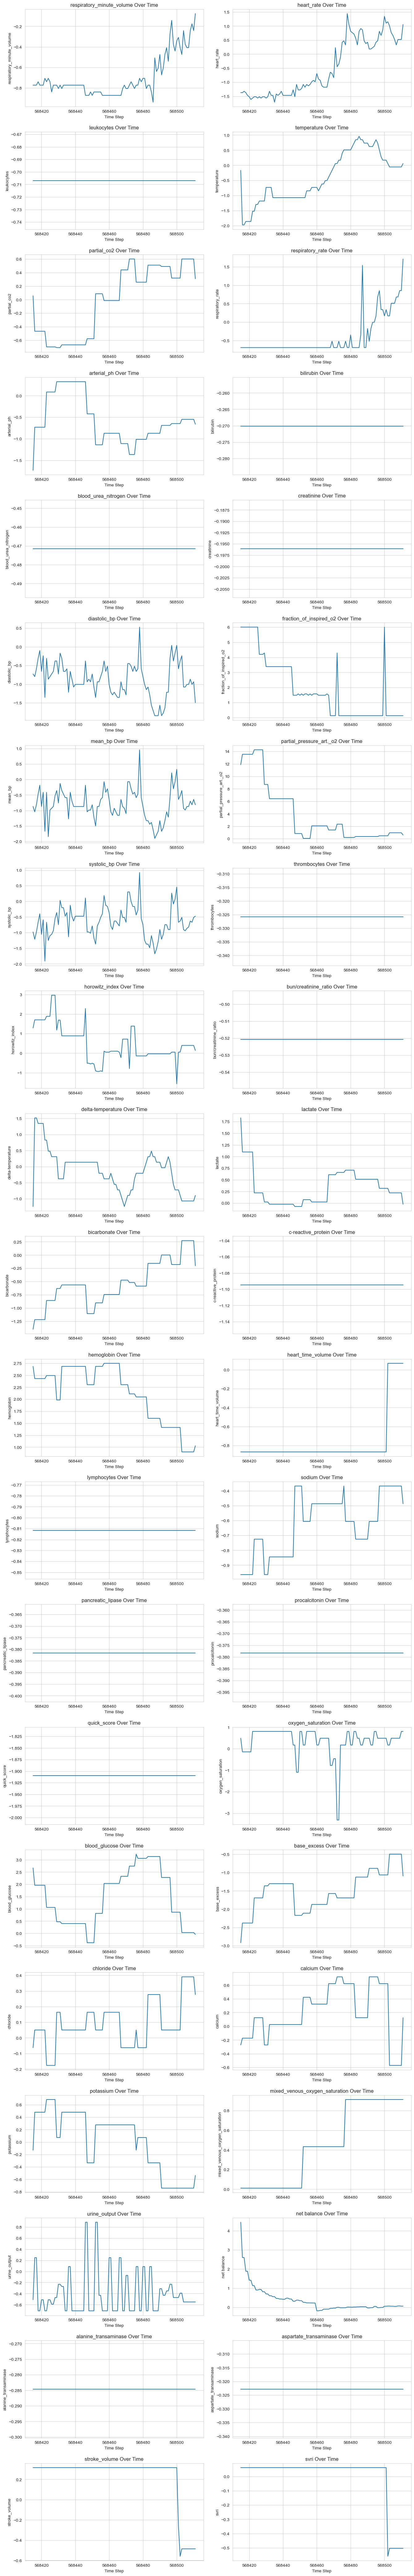

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cols_to_plt = [col for col in patient.columns if col not in ["id", "sepsis", "6hourSepsis", "age"]]
sns.set_style("whitegrid")
num_plots = len(cols_to_plt)
num_columns = 2  # Number of columns in the plot grid
num_rows = num_plots // num_columns + (1 if num_plots % num_columns else 0)  # Calculate required number of rows

fig, axes = plt.subplots(num_rows, num_columns, figsize=(7 * num_columns, 4 * num_rows))
fig.tight_layout(pad=4.0)  # Adjust spacing between plots

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(cols_to_plt):
    sns.lineplot(ax=axes[i], x=patient.index, y=col, data=patient, errorbar=None)
    axes[i].set_title(f"{col} Over Time")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel(col)

# If the number of plots is odd, the last subplot will be empty, so hide it
if num_plots % num_columns:
    axes[-1].set_visible(False)

plt.show()




In [26]:
print(f"Series: {timeseries[0].size()}")
print(f"Targets: {timeseries[1].size()}")

Series: torch.Size([426842, 45])
Targets: torch.Size([426842])


In [27]:
#checking if data is normalized
df_6hr.describe()
#it's somehow close to a standardized form with mean=0 and std=1 being perfectly normalized.

,id,sepsis,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,arterial_ph,bilirubin,blood_urea_nitrogen,creatinine,diastolic_bp,fraction_of_inspired_o2,mean_bp,partial_pressure_art._o2,systolic_bp,thrombocytes,horowitz_index,bun/creatinine_ratio,delta-temperature,lactate,bicarbonate,c-reactive_protein,hemoglobin,heart_time_volume,lymphocytes,sodium,pancreatic_lipase,procalcitonin,quick_score,oxygen_saturation,blood_glucose,base_excess,chloride,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,6hourSepsis
count,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000,426842.000000
mean,12746.572174,0.442831,-0.294010,-0.263470,-0.189804,-0.104821,-0.325455,-0.530321,0.341861,-0.314913,-0.337953,-0.239646,0.190896,-0.211280,0.226258,0.040143,0.233299,0.076387,0.233549,-0.136652,-0.263564,-0.214615,-0.078078,-0.300911,0.295481,-0.399955,0.247583,-0.134461,-0.076142,-0.311455,-0.019522,0.043277,-0.034753,-0.686051,-0.033159,0.143346,-0.232937,0.102132,-0.198966,-0.213013,-0.174579,-0.246357,0.272088,0.149145,-0.167072,0.035845
std,725.767634,0.496722,1.074825,0.929038,0.709325,0.862340,0.676086,1.194462,0.675438,0.389060,0.763096,0.875092,1.076595,0.971330,1.092152,0.941575,1.086353,0.916911,1.072842,0.770811,0.889439,0.490825,0.815983,0.794922,1.069126,0.843247,1.025547,0.761483,0.828754,0.417657,0.880720,0.993327,0.859939,1.062190,0.767363,0.741865,0.802971,0.861596,1.016385,0.773556,0.670398,0.609569,0.749410,0.766513,0.959042,0.185903
min,11460.000000,0.000000,-3.033777,-4.288378,-1.856060,-8.067903,-3.275640,-3.427722,-7.494114,-0.546179,-1.393064,-1.053623,-4.421370,-1.509805,-4.874712,-2.163477,-4.978848,-1.625825,-2.179768,-1.408086,-1.239555,-0.756715,-5.853001,-1.116507,-5.154615,-2.906972,-0.944600,-4.897469,-0.539837,-0.394881,-1.909814,-28.370290,-3.352356,-9.986157,-4.150756,-8.615771,-5.017569,-4.470184,-0.710447,-12.442112,-0.580261,-0.610763,-2.821397,-2.799802,-3.278467,0.000000
25%,12118.000000,0.000000,-0.673448,-0.935944,-0.705422,-0.619533,-0.768621,-1.373239,-0.041447,-0.471240,-0.840120,-0.670247,-0.587579,-0.422862,-0.586493,-0.572559,-0.514572,-0.546926,-0.424844,-0.645086,-0.894861,-0.415104,-0.609074,-0.936234,-0.501794,-0.867504,-0.678531,-0.606219,-0.381617,-0.378305,-0.218014,-0.465227,-0.597598,-1.362455,-0.517229,-0.272186,-0.741863,-0.115007,-0.710447,-0.385261,-0.458547,-0.483745,0.025171,0.009134,-0.671671,0.000000
50%,12691.000000,0.000000,-0.407495,-0.352912,-0.321876,-0.168117,-0.386024,-0.517205,0.395288,-0.412078,-0.487289,-0.458381,0.039769,-0.332283,0.042446,-0.113294,0.106544,-0.171657,0.064134,-0.322222,-0.377821,-0.317501,-0.111805,-0.521502,0.071841,-0.867504,0.045766,-0.248615,-0.321121,-0.378305,-0.118496,0.168979,-0.158787,-0.733643,-0.063038,0.125127,-0.334653,0.010733,-0.471113,-0.298804,-0.328138,-0.382131,0.317126,0.061715,-0.092383,0.000000
75%,13401.000000,1.000000,0.290631,0.327292,0.159787,0.396154,0.016710,0.167623,0.775669,-0.270089,-0.068632,-0.185982,0.806527,-0.332283,0.900089,0.475046,0.844120,0.531972,0.701775,0.181391,0.139220,-0.171096,0.385463,0.124564,0.964163,-0.102703,0.843970,0.228191,-0.088444,-0.369095,0.080539,0.803185,0.377538,-0.074888,0.391153,0.522441,0.276162,0.502262,-0.112112,-0.194415,-0.206423,-0.280517,0.317126,0.202854,0.544833,0.000000
max,14121.000000,1.00

In [138]:
df_2hr
df_2hr_dropped = df_6hr.drop(columns=["sepsis"])
df_2hr_dropped

,id,respiratory_minute_volume,heart_rate,leukocytes,temperature,partial_co2,respiratory_rate,arterial_ph,bilirubin,blood_urea_nitrogen,creatinine,diastolic_bp,fraction_of_inspired_o2,mean_bp,partial_pressure_art._o2,systolic_bp,thrombocytes,horowitz_index,bun/creatinine_ratio,delta-temperature,lactate,bicarbonate,c-reactive_protein,hemoglobin,heart_time_volume,lymphocytes,sodium,pancreatic_lipase,procalcitonin,quick_score,oxygen_saturation,blood_glucose,base_excess,chloride,calcium,potassium,mixed_venous_oxygen_saturation,urine_output,net balance,alanine_transaminase,aspartate_transaminase,stroke_volume,svri,age,6hourSepsis
0,12292,0.190898,0.424464,0.301015,-0.168117,-0.275272,1.879692,-0.041447,0.179544,1.445381,2.396762,-0.239052,1.479290,-0.300612,-0.005231,-0.320473,1.114980,-0.938897,-0.740976,-1.239555,-0.268699,-0.654281,0.416335,1.856485,-0.867504,-0.811566,-0.248615,0.781767,-0.349756,-0.184841,-0.782330,-0.914517,-1.152851,-0.517229,1.019083,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
1,12292,0.157654,0.667394,0.301015,-0.168117,-0.275272,1.708485,-0.041447,0.179544,1.445381,2.396762,-0.936105,0.573504,-1.329784,-0.005231,-1.485067,1.114980,-0.562761,-0.740976,-1.239555,-0.268699,-0.654281,0.416335,1.856485,-0.867504,-0.811566,-0.248615,0.781767,-0.349756,-0.184841,-0.782330,-0.914517,-1.152851,-0.517229,1.019083,-0.334653,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
2,12292,0.024678,0.618808,0.301015,-0.732387,1.003408,2.050899,1.804109,0.179544,1.445381,2.396762,-1.424042,1.026397,-1.615666,-1.310985,-1.368608,1.114980,-1.498923,-0.740976,-0.377821,-0.171096,4.114980,0.416335,-0.884218,-0.867504,-0.811566,-0.010212,0.781767,-0.349756,-0.184841,-2.050742,0.401916,5.255039,-3.242374,-0.868157,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
3,12292,-0.208030,0.278706,0.301015,-0.732387,1.003408,1.366071,1.804109,0.179544,1.445381,2.396762,-1.284632,6.008223,-1.444137,-1.310985,-1.368608,1.114980,-2.018409,-0.740976,-0.377821,-0.171096,4.114980,0.416335,-0.884218,-0.867504,-0.811566,-0.010212,0.781767,-0.349756,-0.184841,-2.050742,0.401916,5.255039,-3.242374,-0.868157,2.923028,0.010733,-0.710447,1.259337,-0.023852,0.117472,0.317126,0.061715,0.371047,0
4,12292,-0.108298,-0.352912,0.301015,-0.732387,1.094023,1.537278,1.677315,0.179544,1.445381,2.396762,-1.284632,1.116975,-1.386961,-0.977793,-1.368608,1.114980,-1.337929,-0.740976,-0.377821,-0.268699,4.092377,0.416335,-0.884218,-0.867504,-0.811566,-0.010212,0.781767,-0.349756,-0.184841,-1.733639,0.255646,5.165209,-3.128827,-0.868157,2.719423,0.010733,-0.710447,0.452120,-0.023852,0.117472,0.317126,0.061715,0.371047,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602563,13304,1.022000,-0.255740,0.500221,0.057592,0.459717,1.023658,0.423464,-0.451520,-0.063366,-0.629891,-0.308758,-1.056912,0.499856,-1.587144,1.154679,1.242303,-0.826056,0.703425,-0.894861,-0.463905,1.266985,0.468437,0.454265,0.024764,0.223144,-0.248615,-0.186168,-0.391198,0.047367,0.803185,-0.475706,1.033018,-0.971420,0.621769,0.683373,0.753742,0.087333,-0.429313,-0.136872,-0.483745,0.499599,-0.350631,0.950335,1
602564,13304,1.022000,-0.401498,0.500221,0.057592,-0.275272,1.023658,0.874287,-0.451520,-0.063366,-0.629891,-0.657284,-1.056912,0.328327,0.054803,1.115859,1.242303,1.044368,0.703425,-0.894861,-0.561509,0.634098,0.468437,0.135578,0.024764,0.223144,-0.248615,-0.186168,-0.391198,0.047367,0.803185,-0.573219,0.344320,-0.630777,0.224456,0.072557,0.753742,-0.710447,-0.413381,-0.136872,-0.483745,0.499599,-0.350631,0.950335,1
602565,13304,1.022000,-0.255740,0.500221,-0.055263,-0.275272,1.023658,0.874287,-0.451520,-0.063366,-0.629891,-0.099642,-1.056912,0.614208,0.054803,1.154679,1.242303,1.044368,0.703425,-1.067208,-0.561509,0.634098,0.468437,0.135578,0.024764,0.22314

In [53]:
max_len = min(df_2hr[df_2hr["sepsis"] == 1].groupby('id').size())
max_len

group_size = df_2hr[df_2hr["sepsis"] == 1].groupby('id').size()
max_size = group_size.max()
ids_with_max_rows = group_size[group_size == max_size].index.tolist()
print(f"ID(s) with sepsis with the maximum number of rows: {ids_with_max_rows}, Length: {max_len}")

ID(s) with sepsis with the maximum number of rows: [13702], Length: 97


In [136]:
import numpy as np

df_2hr_dropped = df_6hr.drop(columns=["sepsis"])


features = df_2hr_dropped.columns[:-1] #all but last column as features
target_column = df_2hr_dropped.columns[-1] #last column as target
print(target_column)
# Number of features, excluding the 'id' column and last column (target)
num_features = len(features) - 1  # Excluding 'id' column 
#num_features = df_2hr_dropped.drop(columns=["id"], axis=1).shape[1] #old with target included


# Pre-allocate a 3D array for features and 2D array for target
num_sequences = df_2hr_dropped['id'].nunique()
print(num_sequences)
data_3d = np.zeros((num_sequences, max_len, num_features))
target_2d = np.zeros((num_sequences, max_len))
print(data_3d.shape)
print(target_2d.shape)

print(features)

# Assuming you have defined 'max_len', 'data_3d', 'target_2d', and 'df_2hr_dropped' correctly
for i, (pid, group) in enumerate(df_2hr_dropped.groupby('id')):
    # Drop 'id' column and select only the relevant features for this group
    features_data = group[features[1:]]  # Assuming 'features[1:]' skips 'id'
    # Ensure we only take the last 'max_len' rows if this patient has more data than 'max_len'
    if len(group) > max_len:
        features_data = features_data.iloc[-max_len:]  # Select last 'max_len' rows
        target_data = group[target_column].iloc[-max_len:]
    else:
        target_data = group[target_column]
    
    # Calculate starting index if we have fewer than 'max_len' data points
    start_idx = max_len - len(features_data)
    
    # Fill the data into our pre-allocated arrays
    data_3d[i, start_idx:, :] = features_data.to_numpy()
    target_2d[i, start_idx:] = target_data.to_numpy()

# Verify shapes and some contents if needed
print(f"data_3d shape: {data_3d.shape}, target_2d shape: {target_2d.shape}")


6hourSepsis
1275
(1275, 97, 43)
(1275, 97)
Index(['id', 'respiratory_minute_volume', 'heart_rate', 'leukocytes',
       'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph',
       'bilirubin', 'blood_urea_nitrogen', 'creatinine', 'diastolic_bp',
       'fraction_of_inspired_o2', 'mean_bp', 'partial_pressure_art._o2',
       'systolic_bp', 'thrombocytes', 'horowitz_index', 'bun/creatinine_ratio',
       'delta-temperature', 'lactate', 'bicarbonate', 'c-reactive_protein',
       'hemoglobin', 'heart_time_volume', 'lymphocytes', 'sodium',
       'pancreatic_lipase', 'procalcitonin', 'quick_score',
       'oxygen_saturation', 'blood_glucose', 'base_excess', 'chloride',
       'calcium', 'potassium', 'mixed_venous_oxygen_saturation',
       'urine_output', 'net balance', 'alanine_transaminase',
       'aspartate_transaminase', 'stroke_volume', 'svri', 'age'],
      dtype='object')
data_3d shape: (1275, 97, 43), target_2d shape: (1275, 97)


In [75]:
print(data_3d.shape)
print(target_2d.shape)

(1275, 97, 43)
(1275, 97)


## Test and validation set

In [76]:
# import numpy as np

# #data_3d
# #target_2d

# from sklearn.model_selection import train_test_split

# # Split into training/testing and validation sets (80% train/test, 20% validation)
# X_train_test, X_val, y_train_test, y_val = train_test_split(data_3d, target_2d, test_size=0.2, random_state=42)

# # If needed, further split the training/testing set into separate training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2




# # Split data into train, test, and validation
# test_fold = 10
# val_fold = 9

# # Extract indices for validation, training, and test to ensure consistency
# val_indices = np.where(Y_copy.strat_fold == val_fold)[0]
# train_test_indices = np.where(Y_copy.strat_fold != val_fold)[0]
# test_indices = np.where(Y_copy.strat_fold == test_fold)[0]
# train_indices = np.where((Y_copy.strat_fold != val_fold) & (Y_copy.strat_fold != test_fold))[0]

# # Validation set
# X_val = X_copy[val_indices]
# y_val = Y_encoded[val_indices]

# # Train set
# X_train = X_copy[train_indices]
# y_train = Y_encoded[train_indices]

# # Test set
# X_test = X_copy[test_indices]
# y_test = Y_encoded[test_indices]


In [77]:
## Emil testar

features_e = data_3d.copy()
targets_e = target_2d.copy()


In [118]:
class BinaryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=5):
        super(BinaryLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Decode the hidden state of each time step
        out = self.fc(out)  # Now out is of shape (batch_size, seq_length, output_dim)
        return out



In [114]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_temp, y_train, y_temp = train_test_split(features_e, targets_e, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)


In [131]:
import torch

# If y_train is not already a flat tensor, flatten it first
y_train_flat = y_train.flatten()

# Count occurrences of 1's (positive class)
count_ones = torch.sum(y_train_flat).item()

# Count occurrences of 0's (negative class) by subtracting count of 1's from total number of elements
count_zeros = y_train_flat.numel() - count_ones

print(f"Count of 0's (Class 0): {count_zeros}")
print(f"Count of 1's (Class 1): {count_ones}")


Count of 0's (Class 0): 75820.0
Count of 1's (Class 1): 10704.0


In [116]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Convert y_train from one-hot encoding to integer class labels if necessary
# Assuming y_train is a PyTorch tensor for simplicity; adapt as needed
if len(y_train.shape) > 1:  # More than one dimension implies one-hot encoding
    y_train_int = torch.argmax(y_train, dim=1).cpu().numpy()
    print("length higher than 1")
else:
    y_train_int = y_train.cpu().numpy()  # Assuming y_train is already class labels

# Compute class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

length higher than 1


In [117]:
#is used to validate a model during training
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# used after with test data
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Squeeze the outputs to remove the extra dimension
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            probabilities = torch.sigmoid(outputs)
            predicted = probabilities > 0.5
            predictions.append(predicted.cpu().numpy())
            actuals.append(labels.cpu().numpy())


    avg_loss = total_loss / len(data_loader)
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    return avg_loss, predictions, actuals

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryLSTM(input_dim=43, hidden_dim=200, num_layers=5).to(device)
criterion = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [120]:
validation_losses = []
training_losses = []
patience = 10
epochs = 100
best_val_loss = float("inf")
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        optimizer.step()
    val_loss = validate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}, Training Loss: {loss.item()} | Validation Loss: {val_loss}")
    
    training_losses.append(loss.item())
    validation_losses.append(val_loss)
    # Early stopping and model saving to prevent overfitting
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()  # Save the current model state
        best_epoch = epoch
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping triggered!")
        print(f"Best epoch: {best_epoch + 1}")
        break

model.load_state_dict(best_model_state)


Epoch 1, Training Loss: 0.3910011053085327 | Validation Loss: 0.38344880441824597
Epoch 2, Training Loss: 0.3682043254375458 | Validation Loss: 0.3708487997452418
Epoch 3, Training Loss: 0.34508806467056274 | Validation Loss: 0.31019552052021027
Epoch 4, Training Loss: 0.16154947876930237 | Validation Loss: 0.12285659958918889
Epoch 5, Training Loss: 0.03542433679103851 | Validation Loss: 0.033531083104511104
Epoch 6, Training Loss: 0.0221516452729702 | Validation Loss: 0.023172193206846714
Epoch 7, Training Loss: 0.024066049605607986 | Validation Loss: 0.040253521874547005
Epoch 8, Training Loss: 0.01879030466079712 | Validation Loss: 0.028941560847063858
Epoch 9, Training Loss: 0.010957404039800167 | Validation Loss: 0.012405141411970058
Epoch 10, Training Loss: 0.009692180901765823 | Validation Loss: 0.009235790775467953
Epoch 11, Training Loss: 0.011011931113898754 | Validation Loss: 0.021794344919423263
Epoch 12, Training Loss: 0.0090006859973073 | Validation Loss: 0.0113902500209

KeyboardInterrupt: 

In [121]:
test_loss, test_predictions, test_actuals = evaluate(model=model, data_loader=test_loader, criterion=criterion, device=device)

In [122]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, auc, roc_curve, roc_auc_score, confusion_matrix

# Squeeze the innermost dimension and convert booleans to integers
test_predictions_squeezed = np.squeeze(test_predictions).astype(int)

# Flatten both arrays
test_actuals_flat = test_actuals.ravel()
test_predictions_flat = test_predictions_squeezed.ravel()

# Proceed with metric calculations
accuracy = accuracy_score(test_actuals_flat, test_predictions_flat)
precision_micro = precision_score(test_actuals_flat, test_predictions_flat, average='binary')
recall_micro = recall_score(test_actuals_flat, test_predictions_flat, average='binary')
f1_micro = f1_score(test_actuals_flat, test_predictions_flat, average='binary')
hamming = hamming_loss(test_actuals_flat, test_predictions_flat)
cm = confusion_matrix(test_actuals_flat, test_predictions_flat)
fpr, tpr, _ = roc_curve(test_actuals_flat, test_predictions_flat)
auc_roc = auc(fpr, tpr)


print(f"Accuracy: {accuracy:.4f}, Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}, AUC-ROC: {auc_roc:.4f}")
print("\n          Predicted")
print("          0      1")
print(f"Actual 0  {cm[0,0]}  {cm[0,1]}")
print(f"       1  {cm[1,0]}    {cm[1,1]}\n")


Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC-ROC: 1.0000

          Predicted
          0      1
Actual 0  16320  0
       1  0    2304



## Training

## Evaluate and visualize results

In [139]:

#train_data = TensorDataset(X_train, y_train)
#test_data = TensorDataset(X_test, y_test)
#val_data = TensorDataset(X_val, y_val)

#batch_size = 32
#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
#test_loader = DataLoader(test_data, batch_size=batch_size)
#val_loader = DataLoader(val_data, batch_size=batch_size)

import torch
from torch.utils.data import DataLoader, TensorDataset


X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Ensure these tensors are on the correct device (CPU or GPU)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)





model.eval()  # Set the model to evaluation mode

# Define a function to calculate accuracy
def calculate_accuracy(outputs, targets):
    predicted = torch.sigmoid(outputs) > 0.5
    correct = (predicted == targets).float().sum()
    return correct / targets.numel()

# Assuming X_test_tensor and y_test_tensor are correctly shaped and on the appropriate device
baseline_outputs = torch.cat([model(xb.to(device)) for xb, _ in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)])
baseline_acc = calculate_accuracy(baseline_outputs, y_test_tensor.to(device))

# Calculate feature importance
importances = []
num_features = X_test_tensor.shape[2]  # Assuming features are in the last dimension

for i in range(num_features):
    # Clone and shuffle the feature values across all examples in the batch
    X_test_shuffled = X_test_tensor.clone()
    shuffling_idx = torch.randperm(X_test_shuffled.size(0))
    X_test_shuffled[:, :, i] = X_test_shuffled[shuffling_idx, :, i]
    
    # Calculate accuracy with the shuffled data
    shuffled_outputs = torch.cat([model(xb.to(device)) for xb, _ in DataLoader(TensorDataset(X_test_shuffled, y_test_tensor), batch_size=64)])
    shuffled_acc = calculate_accuracy(shuffled_outputs, y_test_tensor.to(device))
    
    # Importance is the difference in accuracy
    importance_score = baseline_acc - shuffled_acc
    importances.append(importance_score.item())

# Plotting feature importances
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.bar(np.arange(num_features), importances)
plt.xlabel('Features')
plt.ylabel('Decrease in Accuracy')
plt.title('Feature Importance')
plt.xticks(np.arange(num_features), features, rotation='vertical')
plt.show()

TypeError: must be real number, not builtin_function_or_method

## Result and discussion